In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from tqdm import tqdm
import multiprocessing as mp
import bilby
import numpy as np
from pycbc.waveform import get_td_waveform, taper_timeseries
from gwmat import point_lens
import matplotlib.pyplot as plt
import gwmat
import os
import sys
from pycbc.detector.ground import Detector
import pycbc
import bilby
from bilby.gw.prior import BBHPriorDict

import corner
from modules.gw_utils import scale_signal
import torch
from torch.utils.data import Dataset, DataLoader

from gwtorch.modules.gw_utils import inject_noise_with_target_SNR

from nflows.flows import Flow
from nflows.distributions import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.nn.nets import ResidualNet
from nflows.transforms import CompositeTransform, RandomPermutation

In [2]:
num_samples = 4000
f_lower = 20.0       

priors = BBHPriorDict()

for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'theta_jn', 'phi_12', 'phi_jl', 'luminosity_distance', 'psi', 'phase']:
    priors.pop(key, None)

priors['mass_1'].minimum = 10
priors['mass_2'].minimum = 10
priors['chirp_mass'] = bilby.gw.prior.UniformInComponentsChirpMass(name='chirp_mass', minimum=10, maximum=100)
priors['mass_ratio'] = bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.1, maximum=1)
priors['spin1z'] = bilby.core.prior.Uniform(name='spin1z', minimum=-0.9, maximum=0.9)
priors['spin2z'] = bilby.core.prior.Uniform(name='spin2z', minimum=-0.9, maximum=0.9)
priors['coa_phase'] = bilby.core.prior.Uniform(name='coa_phase', minimum=0.0, maximum=2 * np.pi)
priors['polarization'] = bilby.core.prior.Uniform(minimum=0., maximum=np.pi, boundary="periodic")
priors['Log_Mlz'] = bilby.core.prior.Uniform(minimum=2, maximum=5)
priors['yl'] = bilby.core.prior.PowerLaw(alpha=1, minimum=0.01, maximum=1.0)

parameters_list = priors.sample(num_samples)

samples = [
    {key: parameters_list[key][i] for key in parameters_list}
    for i in range(num_samples)
]

print(f"Length of parameters_list: {len(samples)}")

Length of parameters_list: 4000


In [3]:
samples[0].keys()

dict_keys(['mass_ratio', 'chirp_mass', 'dec', 'ra', 'spin1z', 'spin2z', 'coa_phase', 'polarization', 'Log_Mlz', 'yl'])

In [4]:
def waveform(num):
    parameters = samples[num].copy()

    # Convert masses
    mass1, mass2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(
        parameters['chirp_mass'], parameters['mass_ratio']
    )

    m_lens = np.power(10., parameters.pop("Log_Mlz"))
    y_lens = parameters.pop("yl")

    # Generate unlensed waveform
    sp, sc = get_td_waveform(
        approximant='SEOBNRv4_opt',
        mass1=mass1,
        mass2=mass2,
        spin1z=parameters['spin1z'],
        spin2z=parameters['spin2z'],
        distance=300,
        delta_t=1.0 / 4096,
        coa_phase=parameters['coa_phase'],
        f_lower=f_lower,
    )

    # Frequency-domain lensing
    sp_freq = sp.to_frequencyseries(delta_f=sp.delta_f)
    sc_freq = sc.to_frequencyseries(delta_f=sc.delta_f)
    fs1 = sp_freq.sample_frequencies

    # Ffs_sp = np.vectorize(lambda f: gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens))(fs1)
    Ffs = [gwmat.cythonized_point_lens.Ff_effective(f, ml=m_lens, y=y_lens) for f in fs1]
    time_Delay = point_lens.time_delay(ml=m_lens, y=y_lens)

    sp_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sp_freq),
                                            delta_f=sp_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))
    sc_lensed = pycbc.types.FrequencySeries(np.conj(Ffs) * np.asarray(sc_freq),
                                            delta_f=sc_freq.delta_f).cyclic_time_shift(-1 * (0.1 + time_Delay))

    sp_lensed = sp_lensed.to_timeseries(delta_t=sp_lensed.delta_t)
    sc_lensed = sc_lensed.to_timeseries(delta_t=sc_lensed.delta_t)

    # Detector projection
    detector = Detector('H1')
    lensed_signal = detector.project_wave(
        sp_lensed, sc_lensed,
        ra=parameters['ra'], dec=parameters['dec'], polarization=parameters['polarization']
    )
    lensed_signal = taper_timeseries(lensed_signal, tapermethod="TAPER_STARTEND", return_lal=False)

    # Inject noise with target SNR
    target_snr = np.random.randint(15, 100)
    lensed_noisy, _, distance, _ = inject_noise_with_target_SNR(
        lensed_signal, parameters, mass1, mass2, m_lens, y_lens,
        target_snr, num, gw_signal_type='lensed',
        peak_window=(2.0, 2.2), detector=detector
    )

    # Update local copy of parameters
    parameters['distance'] = distance
    parameters['Log_Mlz'] = np.log10(m_lens)
    parameters['yl'] = y_lens

    lensed_noisy = lensed_noisy.crop(left=24, right=0)

    return np.array(lensed_noisy), parameters

In [5]:
def simulator(num):
    waveform_array, updated_params = waveform(num)
    return updated_params, waveform_array

def simulate_one(ii):
    theta_val, y_val = simulator(ii)
    return theta_val, y_val

In [6]:
num_simulations = num_samples

if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(simulate_one, range(num_simulations))

    # Unzip results
    updated_samples, data_vals = zip(*results)
    updated_samples = list(updated_samples)
    data_vals = list(data_vals)

    # Replace old samples with updated ones
    samples = updated_samples

    theta_vals, data_vals = zip(*results)

In [7]:
samples[0].keys()

dict_keys(['mass_ratio', 'chirp_mass', 'dec', 'ra', 'spin1z', 'spin2z', 'coa_phase', 'polarization', 'distance', 'Log_Mlz', 'yl'])

In [8]:
theta_vals = [list(d.values()) for d in theta_vals]

In [9]:
# convert to torch tensors
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

# create dataset
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

dataset = DataGenerator()

# create dataloaders - 80/10/10 split
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

train_data_loader = DataLoader(
    train_data, batch_size=256,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=256,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [10]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(13, 2, 400)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
num_transforms = 24
num_blocks = 24
hidden_features = 50

context_features = data_vals[0].shape[0]
parameter_space_dim = len(samples[0].keys())

base_dist = StandardNormal([parameter_space_dim])  

transforms = []

for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
                features=parameter_space_dim, 
                hidden_features=hidden_features,
                context_features=context_features,
                num_blocks=num_blocks,
                activation=torch.tanh,
                use_batch_norm=True,
                use_residual_blocks=False,
        ),
        RandomPermutation(features=parameter_space_dim)
    ]
    transforms += block

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [13]:
# base_dist = StandardNormal(shape=[parameter_space_dim])
# transforms = []
# for _ in range(num_transforms):
#     transforms.append(RandomPermutation(features=parameter_space_dim))
#     transforms.append(
#         MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
#             features=parameter_space_dim,
#             hidden_features=hidden_features,
#             context_features=context_features,
#             num_bins=12,
#             use_residual_blocks=True,
#             use_batch_norm=True
#         )
#     )

# transform = CompositeTransform(transforms)
# flow = Flow(transform, base_dist).to(device)

In [14]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [15]:
for i in range(200):
    flow.train()
    train_loss_total = 0.0

    train_loader = tqdm(train_data_loader, desc=f"Epoch {i+1} [Train]", leave=False)
    for idx, val in enumerate(train_loader):
        theta, data = val
        theta = theta.to(device)
        data = data.to(device)

        optimizer.zero_grad()
        loss = -flow.log_prob(theta, context=data).mean()
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item()
        train_loader.set_postfix(loss=loss.item())

    scheduler.step()
    train_loss_avg = train_loss_total / len(train_data_loader)

    flow.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        val_loader = tqdm(val_data_loader, desc=f"Epoch {i+1} [Val]", leave=False)
        for idx, val in enumerate(val_loader):
            theta, data = val
            theta = theta.to(device)
            data = data.to(device)

            val_loss_batch = -flow.log_prob(theta, context=data).mean()
            val_loss_total += val_loss_batch.item()
            val_loader.set_postfix(loss=val_loss_batch.item())

    val_loss_avg = val_loss_total / len(val_data_loader)

    if i == 0 or (i+1) % 10 == 0:
        print(f"[Epoch {i+1}] Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")

[Epoch 1] Train Loss: 103.4860 | Val Loss: 99.4634


[Epoch 10] Train Loss: 35.0201 | Val Loss: 42.0203


[Epoch 20] Train Loss: 23.7659 | Val Loss: 26.4224


[Epoch 30] Train Loss: 21.9513 | Val Loss: 22.3593


[Epoch 40] Train Loss: 21.3396 | Val Loss: 21.5875


[Epoch 50] Train Loss: 21.0972 | Val Loss: 21.2708


[Epoch 60] Train Loss: 20.9500 | Val Loss: 21.1426


[Epoch 70] Train Loss: 20.8285 | Val Loss: 21.0262


[Epoch 80] Train Loss: 20.8356 | Val Loss: 21.0645


[Epoch 90] Train Loss: 20.7612 | Val Loss: 20.9439


[Epoch 100] Train Loss: 20.7345 | Val Loss: 21.0362


[Epoch 110] Train Loss: 20.7307 | Val Loss: 21.0232


[Epoch 120] Train Loss: 20.7317 | Val Loss: 21.0152


[Epoch 130] Train Loss: 20.7085 | Val Loss: 21.0673


[Epoch 140] Train Loss: 20.7273 | Val Loss: 20.9609


[Epoch 150] Train Loss: 20.7203 | Val Loss: 20.9754


[Epoch 160] Train Loss: 20.6983 | Val Loss: 21.0021


[Epoch 170] Train Loss: 20.7418 | Val Loss: 20.9778


[Epoch 180] Train Loss: 20.7079 | Val Loss: 20.9621


[Epoch 190] Train Loss: 20.7078 | Val Loss: 21.0019


[Epoch 200] Train Loss: 20.7002 | Val Loss: 20.9893


In [16]:
torch.save(flow.state_dict(), "flow_bbh.pth")

In [17]:
theta_test, data_test = next(iter(test_data_loader))
theta_test = theta_test.to(device)
data_test = data_test.to(device)
with torch.no_grad():
        posterior_samples = flow.sample(5000, context=data_test.reshape(tuple(data_test.shape)))

theta_test = theta_test.squeeze(0)

In [18]:
theta_test

tensor([ 8.6980e-01,  2.3373e+01, -4.9220e-01,  1.9185e+00, -4.5165e-01,
        -5.7187e-01,  5.7107e+00,  1.2619e+00,  6.4846e+02,  2.8257e+00,
         8.1148e-01], device='cuda:0')

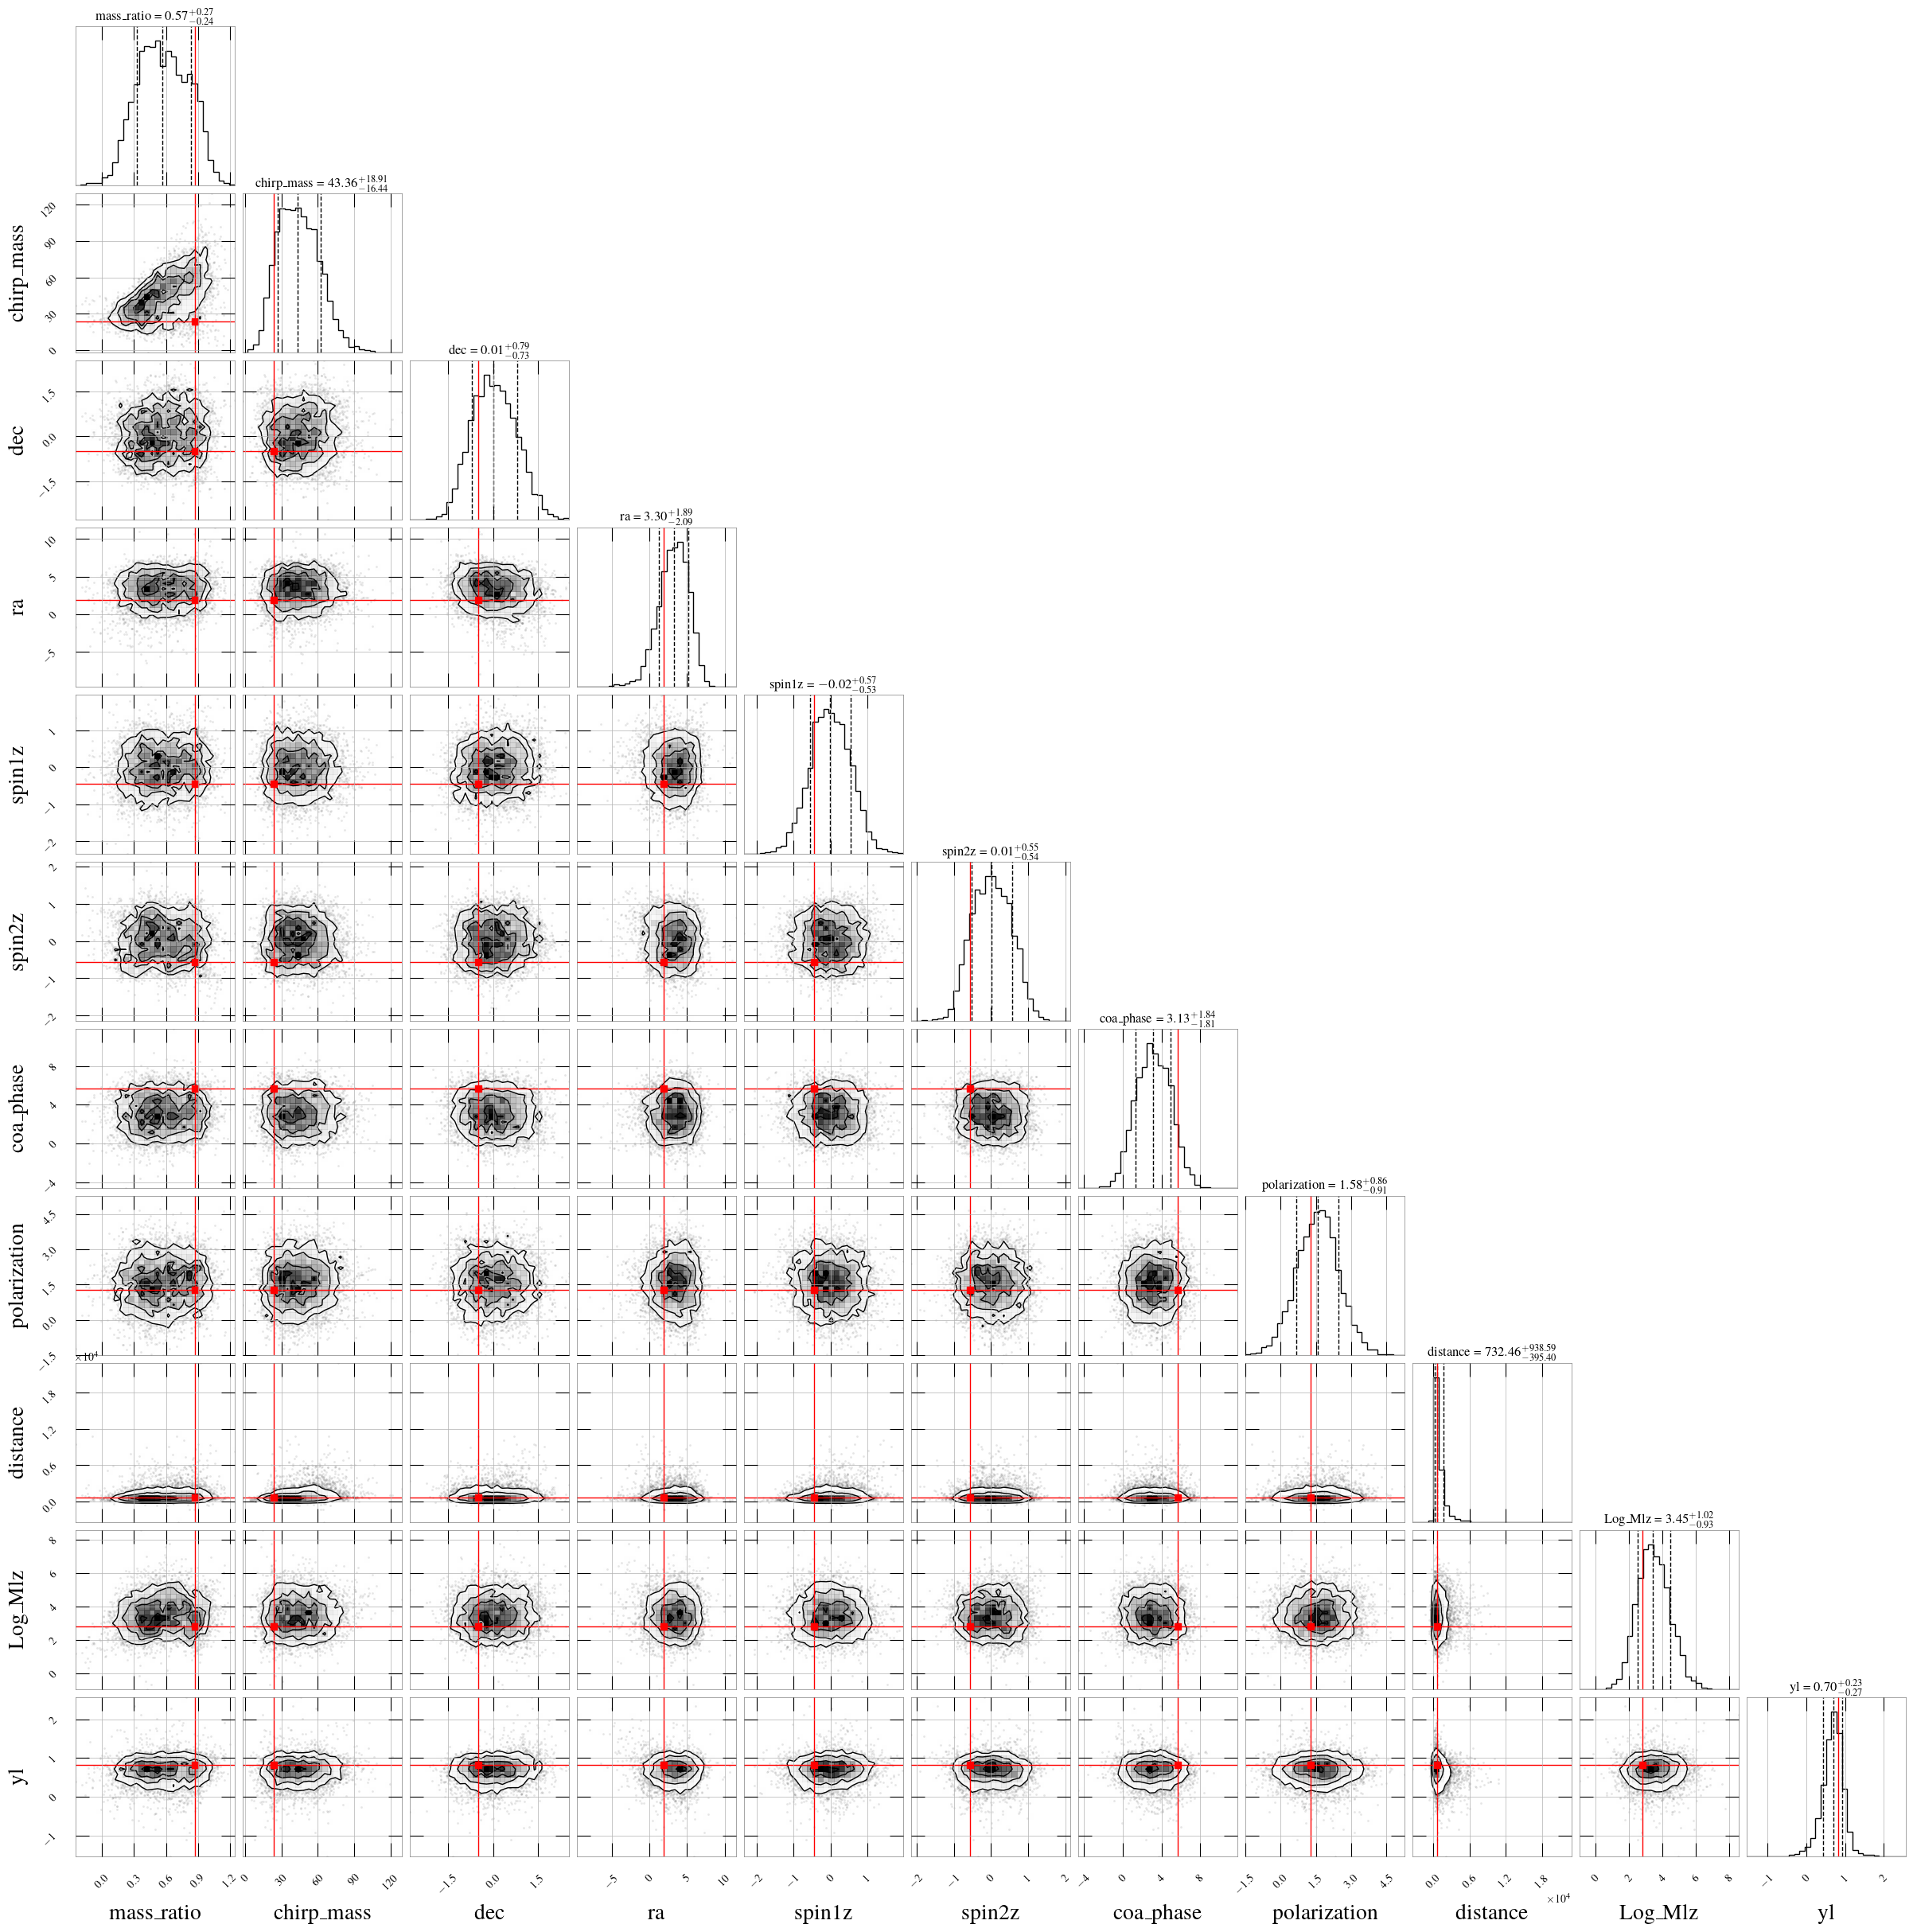

In [19]:
from matplotlib import rc

data = posterior_samples.squeeze(0).cpu().numpy()

rc('text', usetex=True)
rc('font', family='serif')
rc('font', serif='times')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=1)
rc("lines", linewidth=1)
rc('axes', labelsize=20)
rc("axes", linewidth=0.5)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)
rc('legend', fontsize=10)
rc('ytick', right=True, direction='in')
rc('xtick', top=True, direction='in')
rc('xtick.major', pad=15)
rc('ytick.major', pad=15)
rc('xtick.major', size=12)
rc('ytick.major', size=12)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)

figure = corner.corner(
    data,
    bins=30,  # Number of bins
    labels=list(samples[0].keys()),
    quantiles=[0.16, 0.5, 0.84], 
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truths=theta_test.cpu().numpy(),
    truth_color="red",
)

def set_tick_sizes_corner(fig, major=12, minor=7):
    for ax in fig.get_axes():
        for line in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
            line.set_markersize(major)
        for tick in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
            tick.tick1line.set_markersize(minor)
            tick.tick2line.set_markersize(minor)

set_tick_sizes_corner(figure)

figure.savefig("Injection_PE.pdf", bbox_inches='tight')
plt.show()


In [20]:
from modules.pp_plot_code import calculate_pp_values, compute_pp_statistics, plot_overlay_pp_plot

Computing P-P values: 100%|██████████| 400/400 [10:53<00:00,  1.63s/it]


Generating overlaid P-P plot...


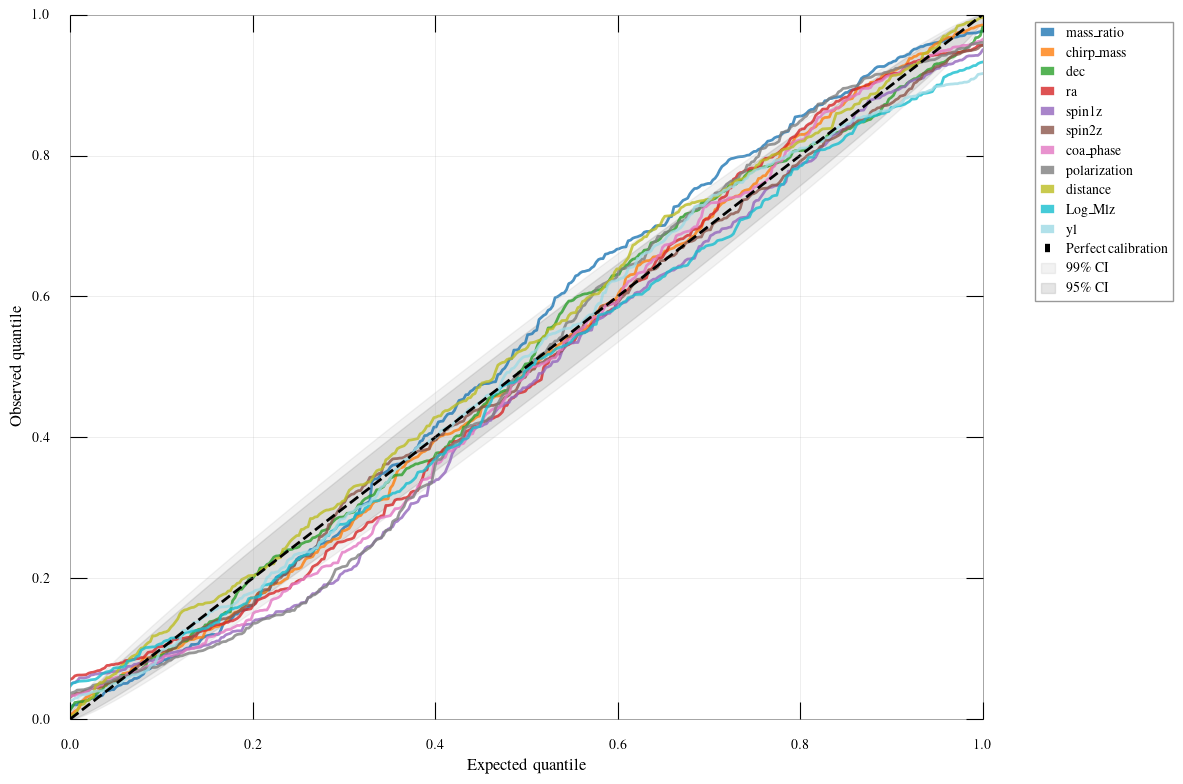

P-P Plot Statistics:

mass_ratio:
  Mean P-value: 0.5193 (should be ~0.5)
  Std P-value: 0.3129 (should be ~0.2887)
  KS test p-value: 0.0171 (>0.05 indicates good calibration)

chirp_mass:
  Mean P-value: 0.4973 (should be ~0.5)
  Std P-value: 0.3016 (should be ~0.2887)
  KS test p-value: 0.5245 (>0.05 indicates good calibration)

dec:
  Mean P-value: 0.5018 (should be ~0.5)
  Std P-value: 0.2919 (should be ~0.2887)
  KS test p-value: 0.2963 (>0.05 indicates good calibration)

ra:
  Mean P-value: 0.4922 (should be ~0.5)
  Std P-value: 0.3004 (should be ~0.2887)
  KS test p-value: 0.1175 (>0.05 indicates good calibration)

spin1z:
  Mean P-value: 0.4686 (should be ~0.5)
  Std P-value: 0.2958 (should be ~0.2887)
  KS test p-value: 0.0009 (>0.05 indicates good calibration)

spin2z:
  Mean P-value: 0.4905 (should be ~0.5)
  Std P-value: 0.2852 (should be ~0.2887)
  KS test p-value: 0.4206 (>0.05 indicates good calibration)

coa_phase:
  Mean P-value: 0.4861 (should be ~0.5)
  Std P-value:

In [21]:
if __name__ == "__main__":

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # flow.load_state_dict(torch.load('trained_flow_model.pth'))
    
    pp_values, parameter_names = calculate_pp_values(
        flow, test_data_loader, samples[0], device, num_posterior_samples=5000
    )
    

    # print("Generating P-P plots in subplot grid...")
    # fig = plot_pp_plot(pp_values, parameter_names, confidence_level=0.95)
    
    print("Generating overlaid P-P plot...")
    plot_overlay_pp_plot(pp_values, parameter_names, confidence_level=0.95)

    compute_pp_statistics(pp_values, parameter_names)
    
    np.save('pp_values.npy', pp_values)
    np.save('parameter_names.npy', parameter_names)
    
    print("\nP-P analysis completed!")